In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import joblib
import math
import ast
import logging
from pathlib import Path
from msig import Motif, NullModel

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Load YAML configuration
config_path = "config.yaml"  # Ensure this path is correct
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

# Convert base_dir to absolute
BASE_DIR = Path(config["base_dir"]).resolve()

# Convert other paths to absolute using BASE_DIR
RESULTS_DIR = BASE_DIR / config["results_dir"]
RESULTS_MOTIF_DIR = BASE_DIR / config["results_motif_dir"]
IMAGES_DIR = BASE_DIR / config["images_dir"]
DATA_DIR = BASE_DIR / config["data_dir"]
DATASET_PATH = BASE_DIR / config["dataset_path"]

# Extract remaining parameters from YAML
TOWNSHIP_NAME = config["township_name"]
VARIABLES = config["variables"]
NORMALIZE_FLAGS = config["normalize_flags"]
STUMPY_EXCL_ZONE_DENOM = config["stumpy_excl_zone_denom"]
TOP_K_MP = config["top_k_mp"]
INCLUDE = config["include"]
NORMALIZE = config["normalize"]
SUBSEQUENCES_LENGTHS = config["subsequences_lengths"]
NTOP_MOTIFS = config["ntop_motifs"]
MOTIF_SIZE = config["motif_size"]
LOOKBACK_PERIOD = config["lookback_period"]
STEP = config["step"]
FORECAST_PERIOD = config["forecast_period"]

# Print resolved paths for debugging
print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")
print(f"Dataset path: {DATASET_PATH}")

# Handling different environments
if '__file__' in globals():
    # For standalone scripts
    base_dir = Path(__file__).parent.resolve()
else:
    # For Jupyter or interactive environments
    base_dir = Path(os.getcwd()).resolve()

# Add the parent directory of `utils` to the Python path
sys.path.append(str(base_dir / "../"))

Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity
Dataset path: /home/mgsilva/motifpred/data/populationdensity/hourly_township.csv


In [2]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
mp_stats_table = mp_stats_table[mp_stats_table["m"] == MOTIF_SIZE]
top_motifs = mp_stats_table.sort_values(by=["#Matches", "ID"], ascending=[False, True]).head(NTOP_MOTIFS)
top_motifs = top_motifs[["m", "Indices"]]

In [3]:
# read csv
data_df = pd.read_csv(
    DATASET_PATH,
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)

data_df = data_df[data_df["township_name"] == TOWNSHIP_NAME]
#set index to one_time and township_name
data_df = data_df.set_index(["one_time", "township_name"]).sort_index()[VARIABLES]
data = data_df.to_numpy().T
data_univar = data[0]
data_df

,,sum_terminals
one_time,township_name,
2021-09-15 00:00:00,Avenidas Novas,260700.0
2021-09-15 01:00:00,Avenidas Novas,276675.0
2021-09-15 02:00:00,Avenidas Novas,284563.0
2021-09-15 03:00:00,Avenidas Novas,279563.0
2021-09-15 04:00:00,Avenidas Novas,281460.0
...,...,...
2021-11-30 19:00:00,Avenidas Novas,391367.0
2021-11-30 20:00:00,Avenidas Novas,352361.0
2021-11-30 21:00:00,Avenidas Novas,388246.0


In [4]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [5]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.lstm_pytorch import LSTM
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():

    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "LSTM"
    model_name = "LSTMSeries"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1,3,5]]  
        },
        "batch_size": {
            "type": "categorical",
            "args": [[4, 8, 16, 32]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


Evaluating motif 26 with size 12 and 58 indexes
X_series shape: torch.Size([1173, 504, 1])
X_indices shape: torch.Size([1173, 18, 1])
X_mask shape: torch.Size([1173, 504])
y shape: torch.Size([1173, 1])
Best epoch: 28
Test Loss: 120.52042388916016, Test MAE: 8.71350383758545, Test RMSE: 10.978178977966309
Evaluating motif 5 with size 12 and 47 indexes
X_series shape: torch.Size([1032, 504, 1])
X_indices shape: torch.Size([1032, 16, 1])
X_mask shape: torch.Size([1032, 504])
y shape: torch.Size([1032, 1])
Best epoch: 164
Test Loss: 134.16517639160156, Test MAE: 8.819411277770996, Test RMSE: 11.582969665527344
Evaluating motif 23 with size 12 and 46 indexes
X_series shape: torch.Size([1122, 504, 1])
X_indices shape: torch.Size([1122, 16, 1])
X_mask shape: torch.Size([1122, 504])
y shape: torch.Size([1122, 1])
Best epoch: 63
Test Loss: 134.2666015625, Test MAE: 9.565382957458496, Test RMSE: 11.587347030639648
Evaluating motif 11 with size 12 and 44 indexes
X_series shape: torch.Size([1050,

Evaluating motif 26 with size 12 and 58 indexes
X_series shape: torch.Size([1173, 504, 1])
X_indices shape: torch.Size([1173, 18, 1])
X_mask shape: torch.Size([1173, 504])
y shape: torch.Size([1173, 1])
Best epoch: 83
Test Loss: 95.84618377685547, Test MAE: 7.4842681884765625, Test RMSE: 9.790106773376465
Best hyperparameters: {'learning_rate': 0.0005238148099502369, 'num_layers': 1, 'batch_size': 4, 'hidden_size_layer_0': 128}
Early stopping at epoch 94, with best epoch being 83


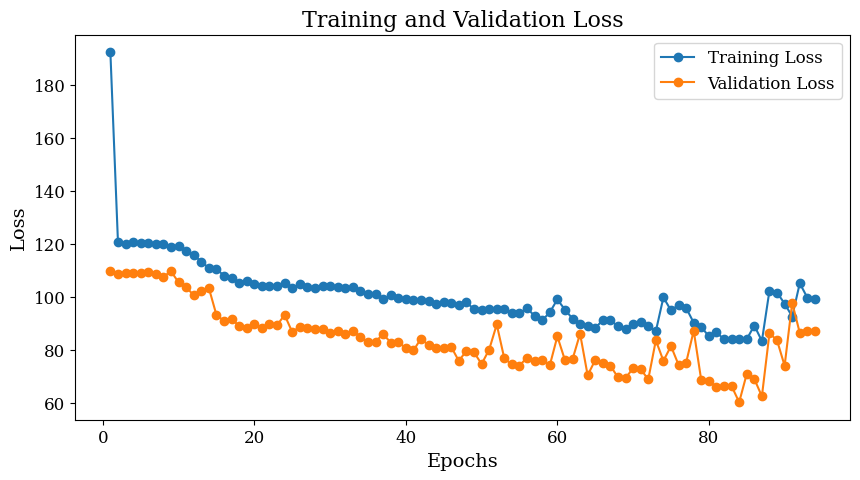

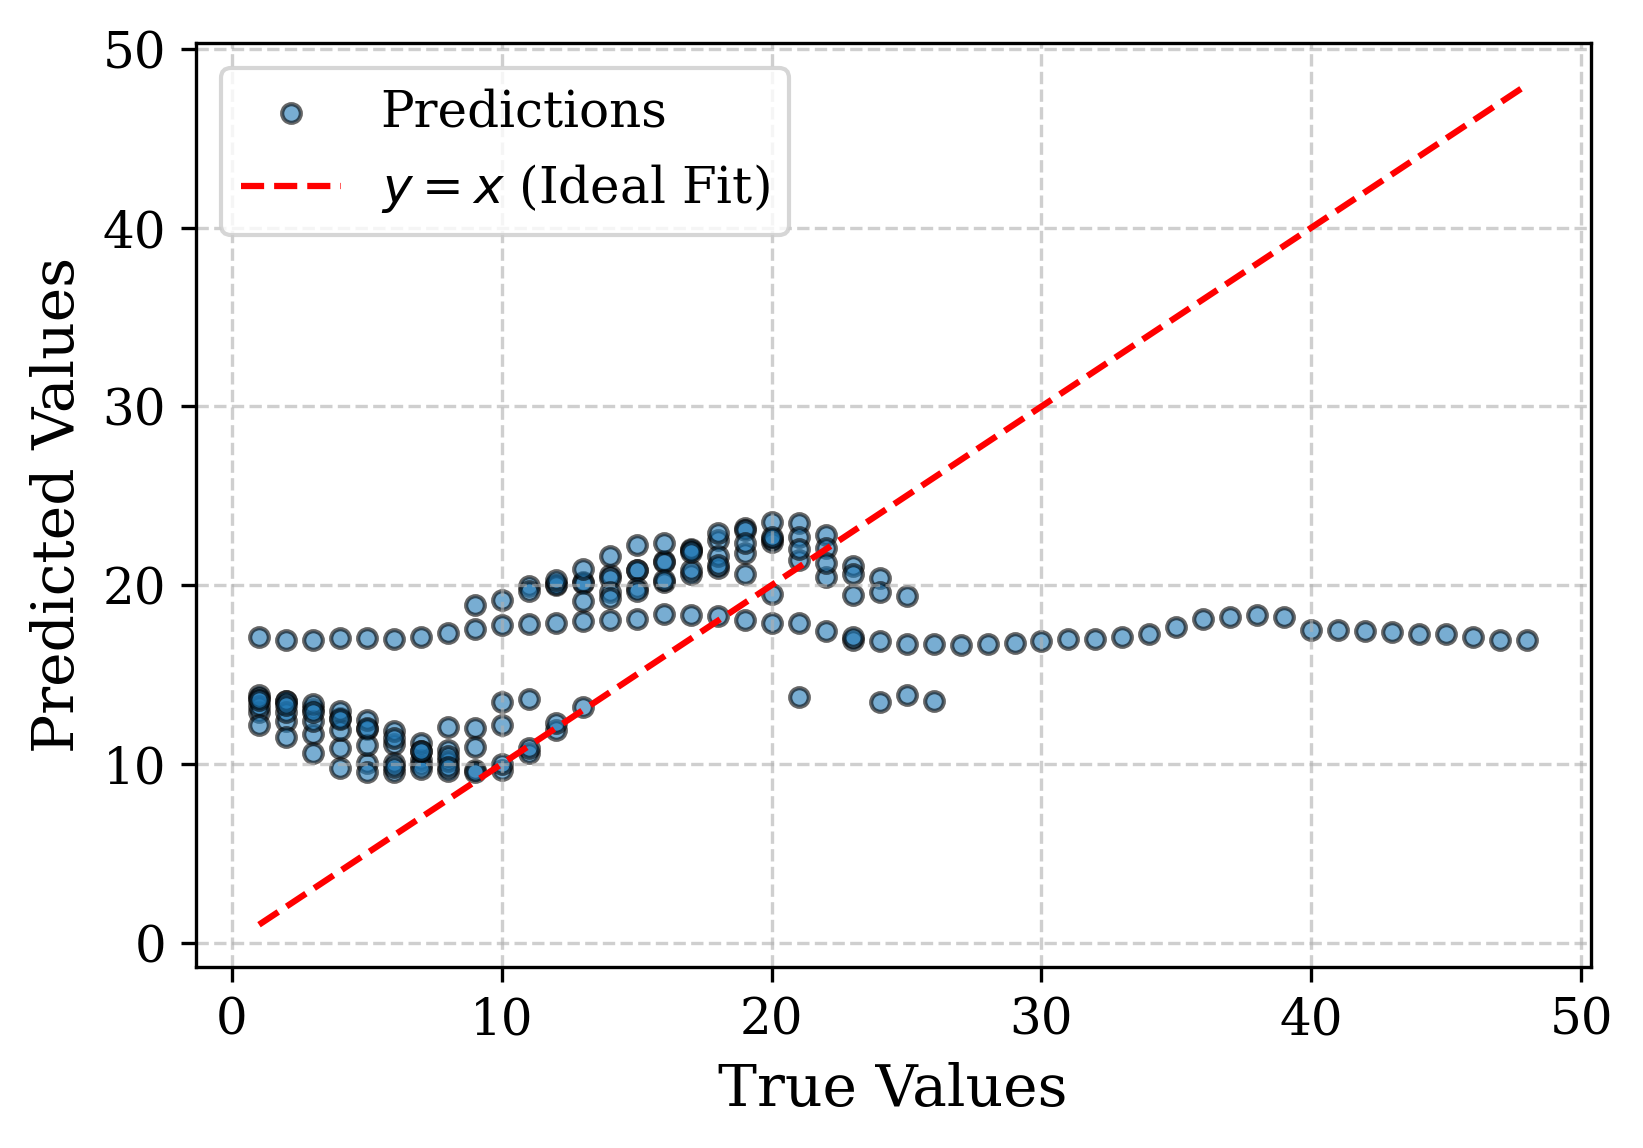

Evaluating motif 5 with size 12 and 47 indexes
X_series shape: torch.Size([1032, 504, 1])
X_indices shape: torch.Size([1032, 16, 1])
X_mask shape: torch.Size([1032, 504])
y shape: torch.Size([1032, 1])
Best epoch: 27
Test Loss: 127.81010437011719, Test MAE: 8.860823631286621, Test RMSE: 11.305313110351562
Best hyperparameters: {'learning_rate': 0.0009973516641819476, 'num_layers': 1, 'batch_size': 32, 'hidden_size_layer_0': 16}
Early stopping at epoch 38, with best epoch being 27


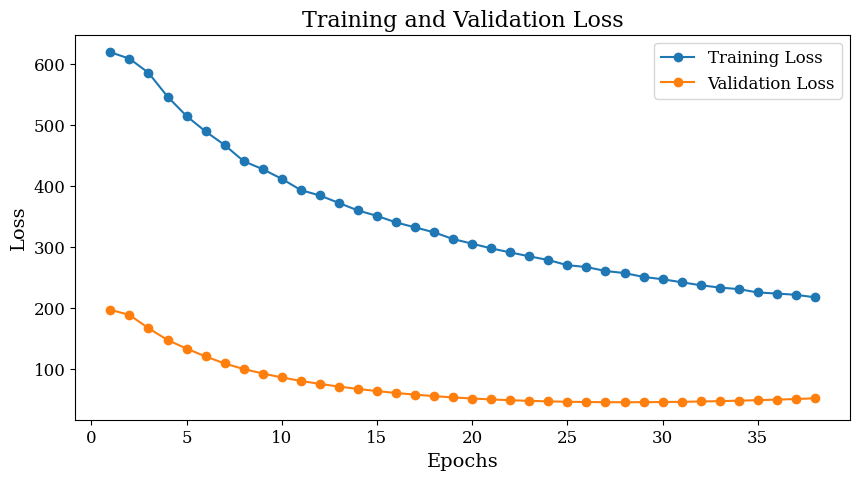

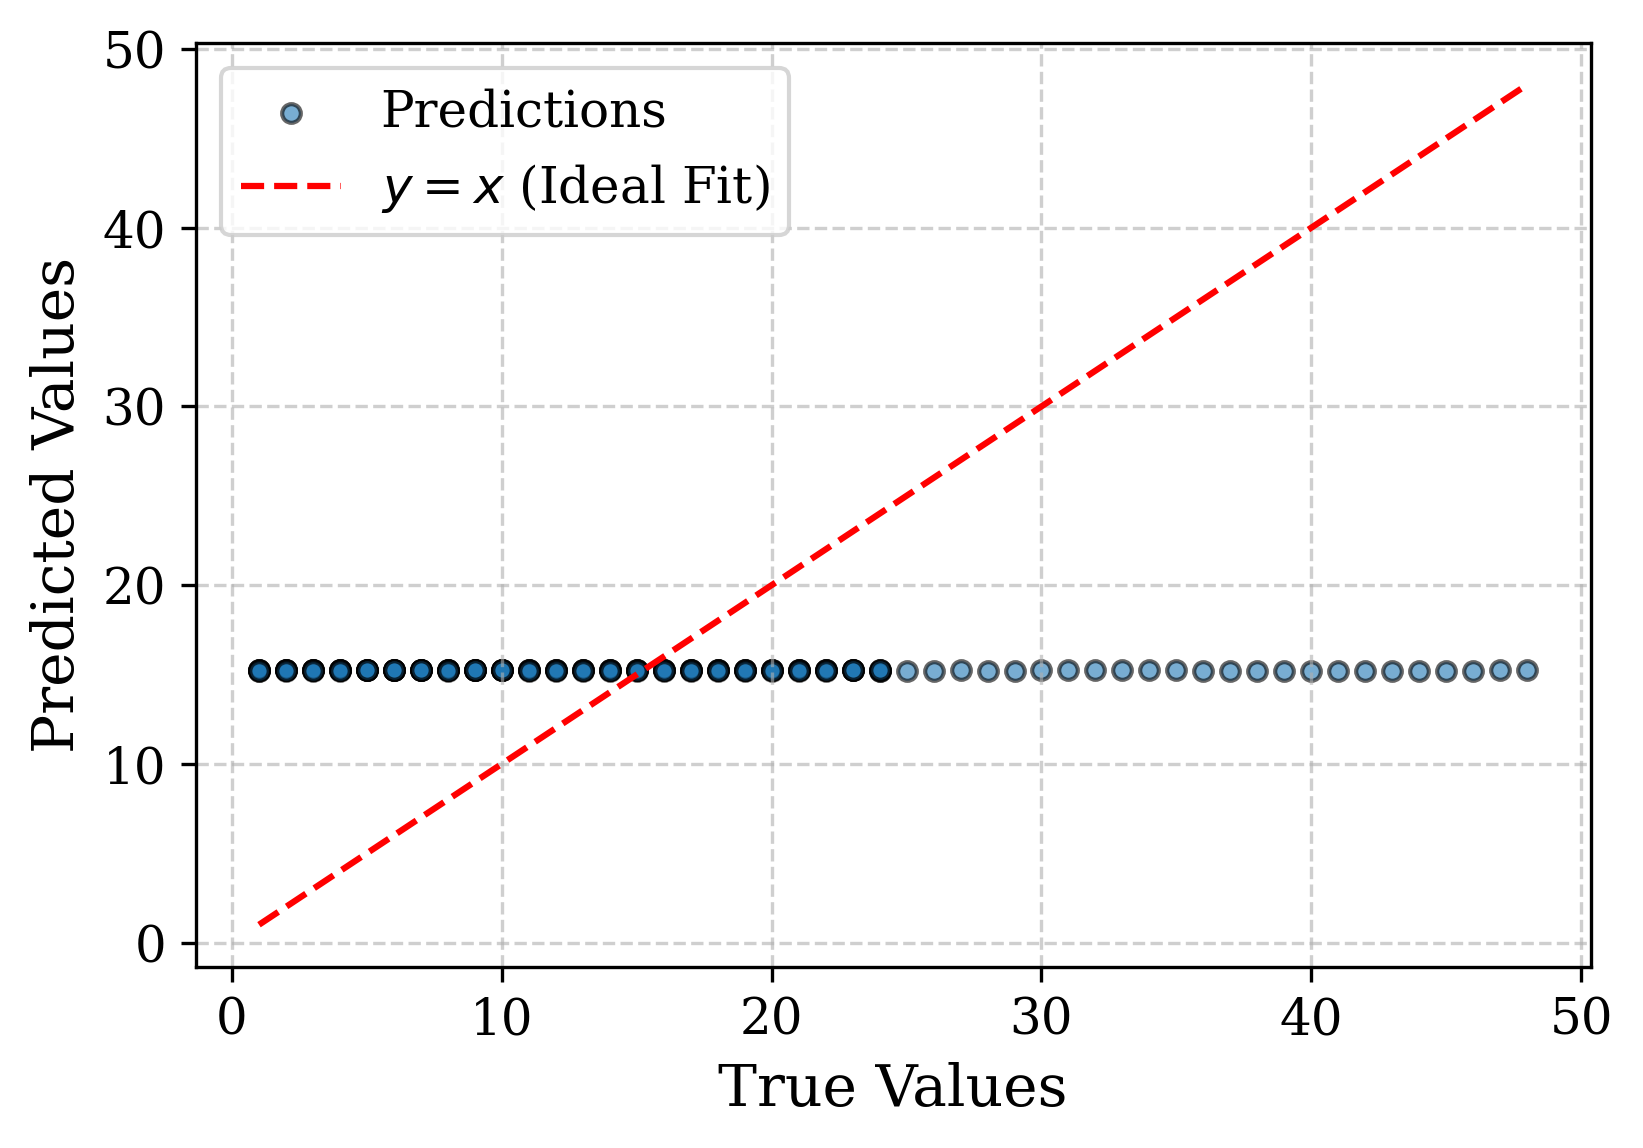

Evaluating motif 23 with size 12 and 46 indexes
X_series shape: torch.Size([1122, 504, 1])
X_indices shape: torch.Size([1122, 16, 1])
X_mask shape: torch.Size([1122, 504])
y shape: torch.Size([1122, 1])
Best epoch: 386
Test Loss: 135.71487426757812, Test MAE: 9.544173240661621, Test RMSE: 11.649672508239746
Best hyperparameters: {'learning_rate': 5.1522953089845116e-05, 'num_layers': 3, 'batch_size': 16, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 16}
Early stopping at epoch 397, with best epoch being 386


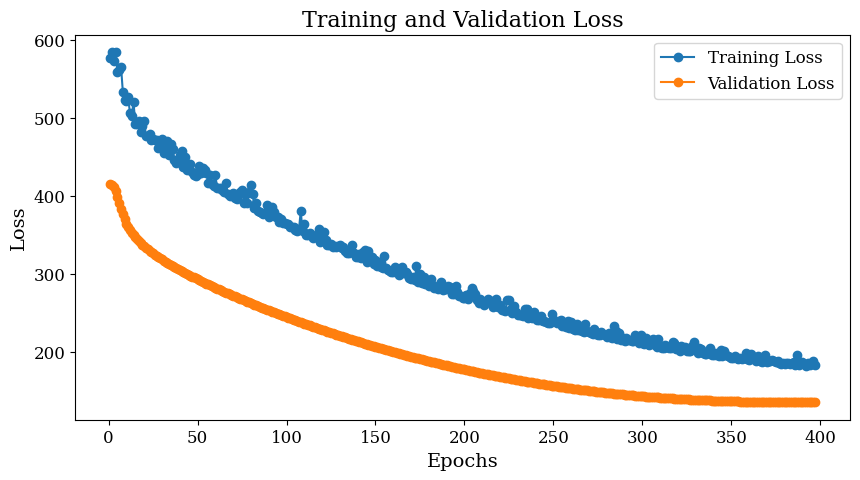

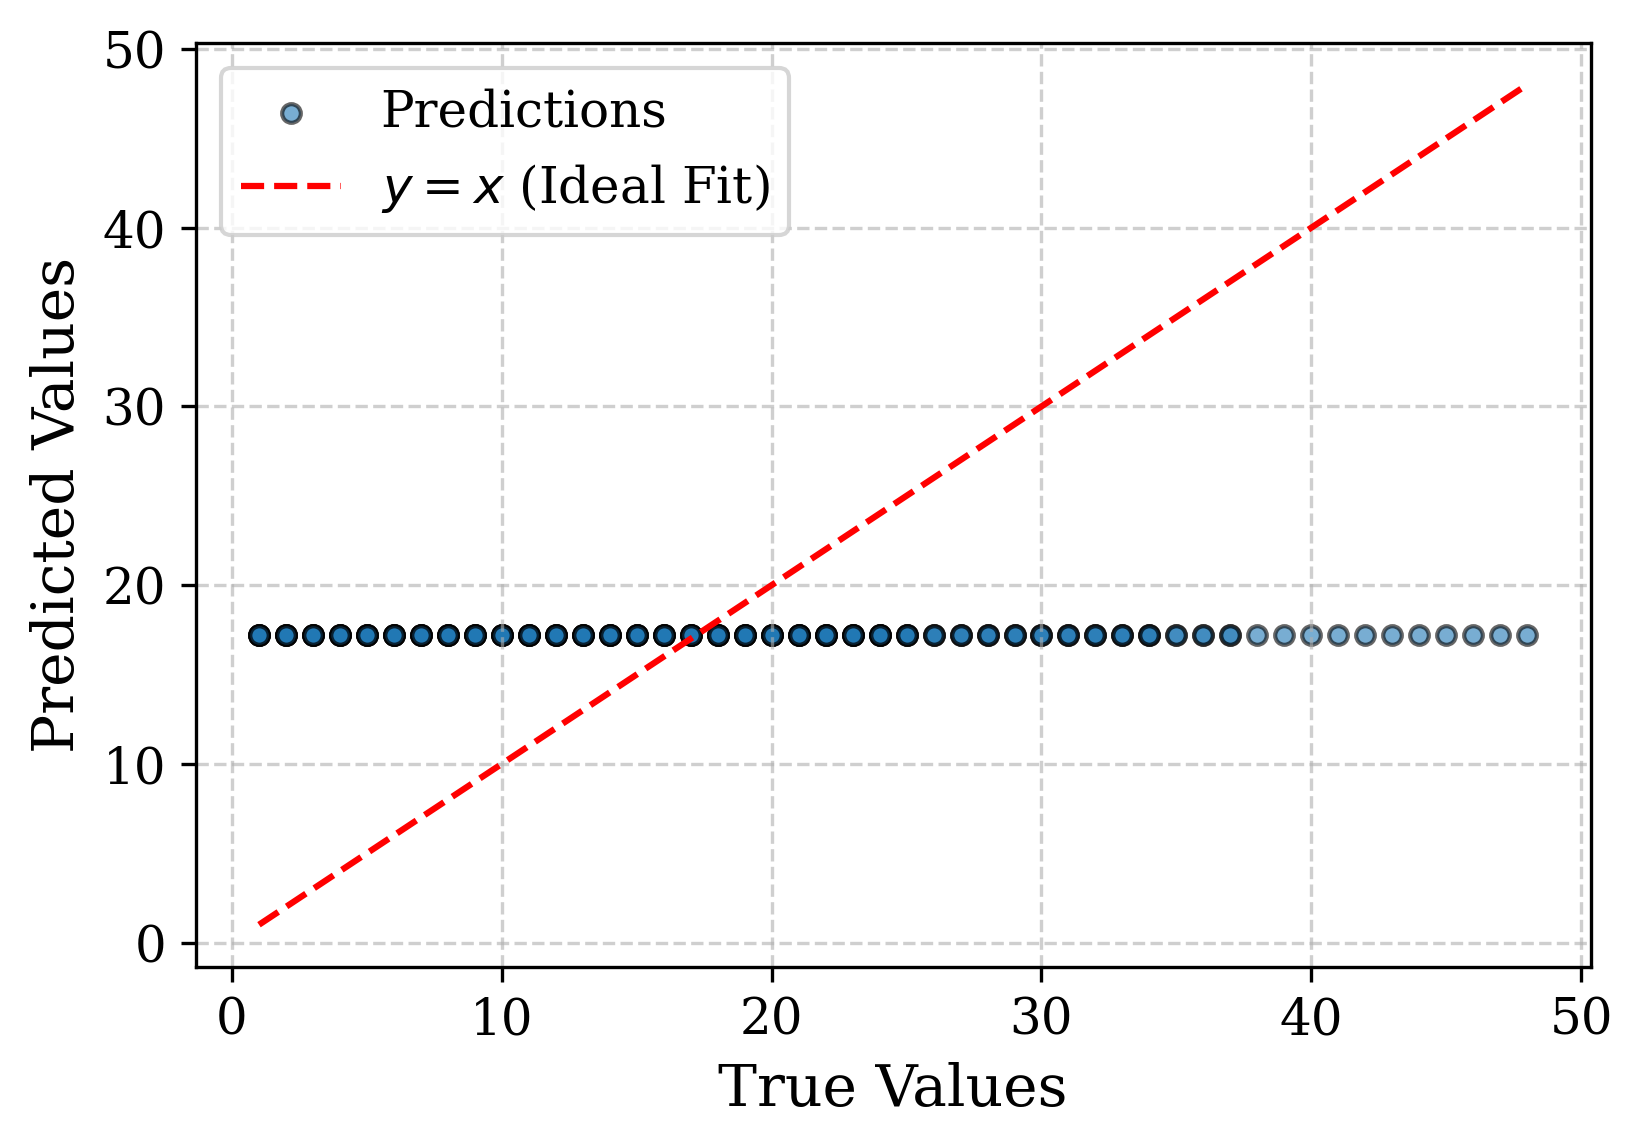

Evaluating motif 11 with size 12 and 44 indexes
X_series shape: torch.Size([1050, 504, 1])
X_indices shape: torch.Size([1050, 15, 1])
X_mask shape: torch.Size([1050, 504])
y shape: torch.Size([1050, 1])
Best epoch: 41
Test Loss: 168.10658264160156, Test MAE: 10.682856559753418, Test RMSE: 12.965592384338379
Best hyperparameters: {'learning_rate': 0.000996158274507557, 'num_layers': 1, 'batch_size': 32, 'hidden_size_layer_0': 16}
Early stopping at epoch 52, with best epoch being 41


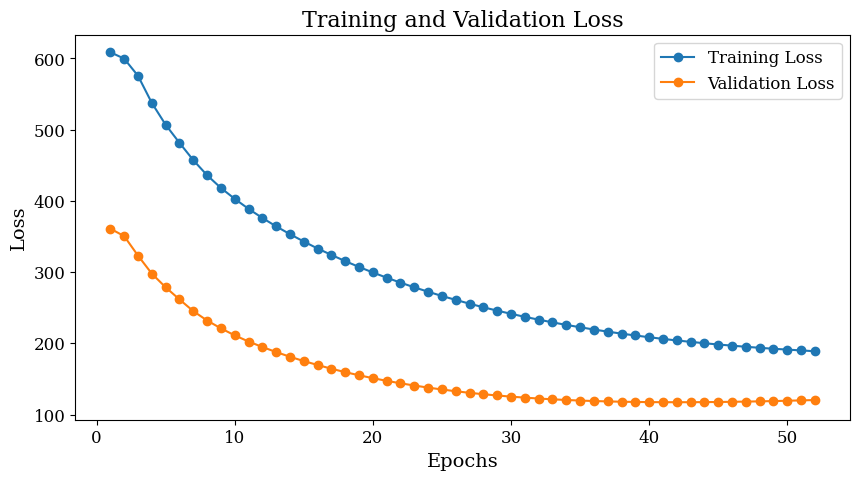

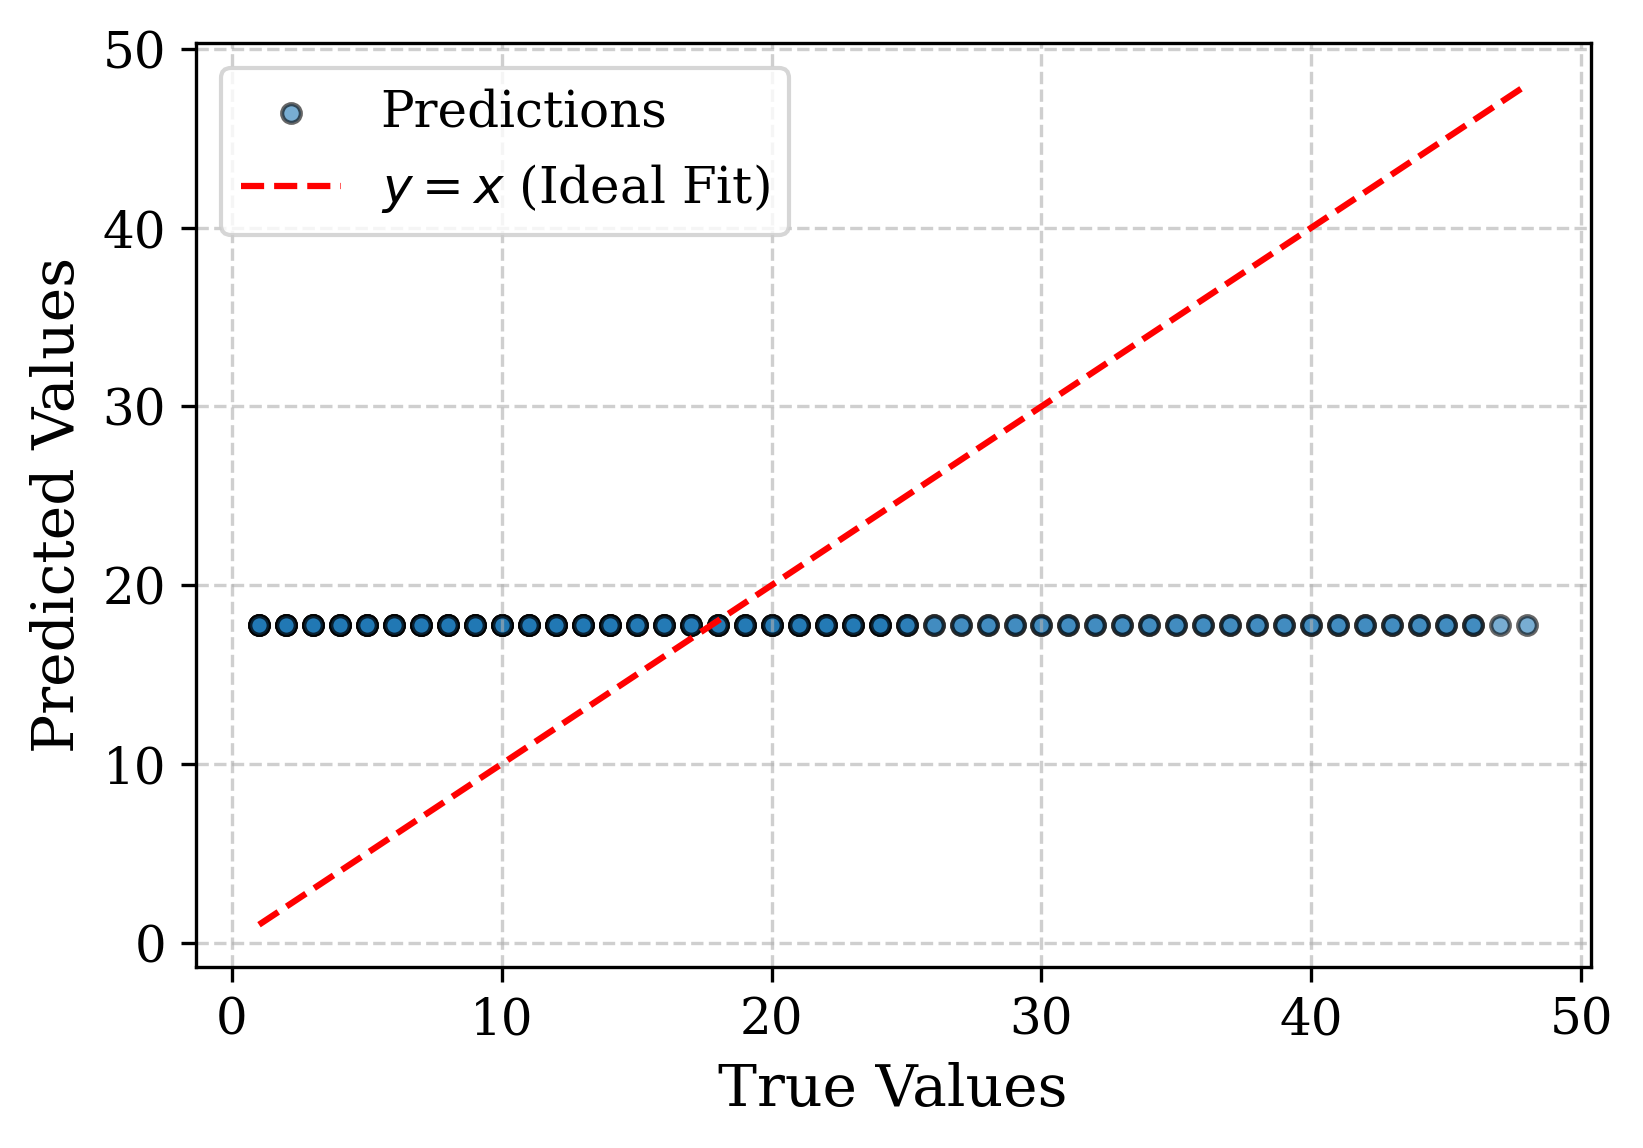

Evaluating motif 6 with size 12 and 38 indexes
X_series shape: torch.Size([979, 504, 1])
X_indices shape: torch.Size([979, 12, 1])
X_mask shape: torch.Size([979, 504])
y shape: torch.Size([979, 1])
Best epoch: 69
Test Loss: 187.75741577148438, Test MAE: 11.20423698425293, Test RMSE: 13.702460289001465
Best hyperparameters: {'learning_rate': 0.0006270292167231985, 'num_layers': 1, 'batch_size': 32, 'hidden_size_layer_0': 16}
Early stopping at epoch 80, with best epoch being 69


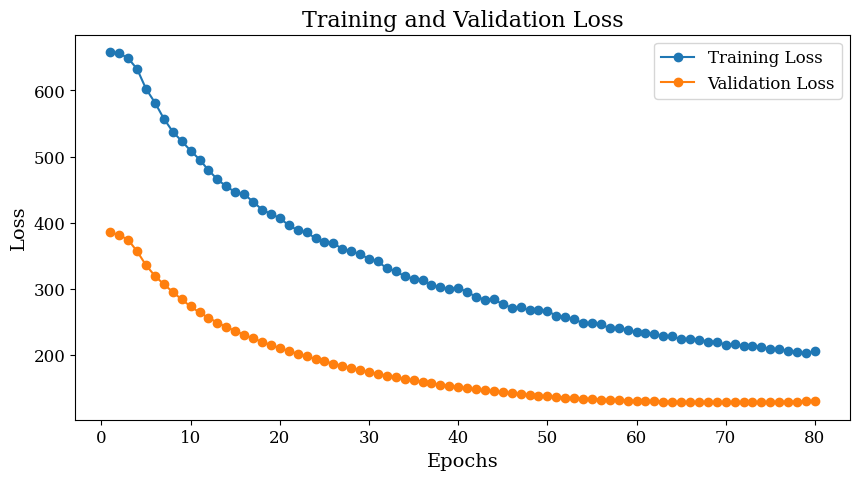

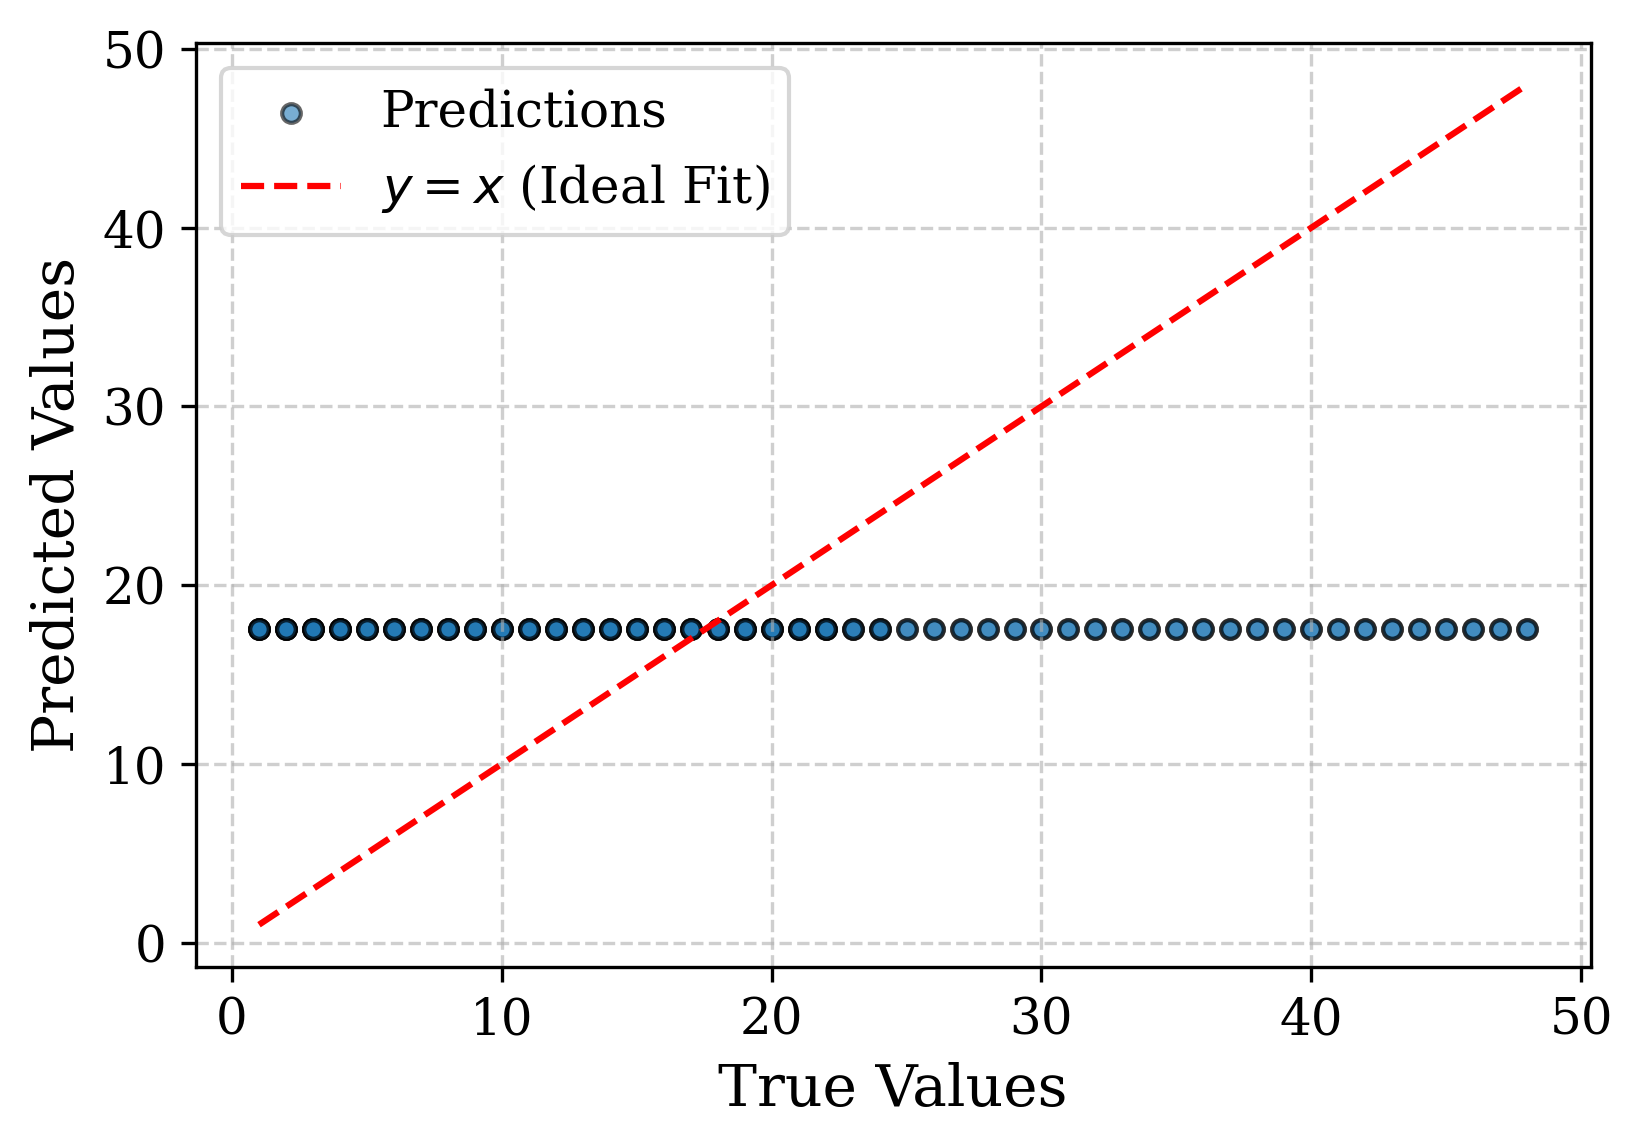

Aggregated Results Across Top 5 Motifs:
Mean Test Loss: 143.04703216552736 ± 32.06507155441301
Mean Test MAE: 9.55527172088623 ± 1.3237802661543427
Mean Test RMSE: 11.882629013061523 ± 1.3602063993860414


In [6]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.lstm_pytorch import LSTM
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():


    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "LSTM"
    model_name = "LSTMSeries_Masking"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1,3,5]]  
        },
        "batch_size": {
            "type": "categorical",
            "args": [[4, 8, 16, 32]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series, "X_mask": X_mask}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    plot_best_model_results_traindevtest( study.trials_dataframe(),
       save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    )    
    plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


Evaluating motif 26 with size 12 and 58 indexes
X_series shape: torch.Size([1173, 504, 1])
X_indices shape: torch.Size([1173, 18, 1])
X_mask shape: torch.Size([1173, 504])
y shape: torch.Size([1173, 1])
Best epoch: 56
Test Loss: 120.23932647705078, Test MAE: 8.675817489624023, Test RMSE: 10.96536922454834
Best hyperparameters: {'learning_rate': 3.0301941435404453e-05, 'num_layers': 5, 'batch_size': 32, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 16, 'hidden_size_layer_2': 32, 'hidden_size_layer_3': 16, 'hidden_size_layer_4': 256}


Early stopping at epoch 67, with best epoch being 56


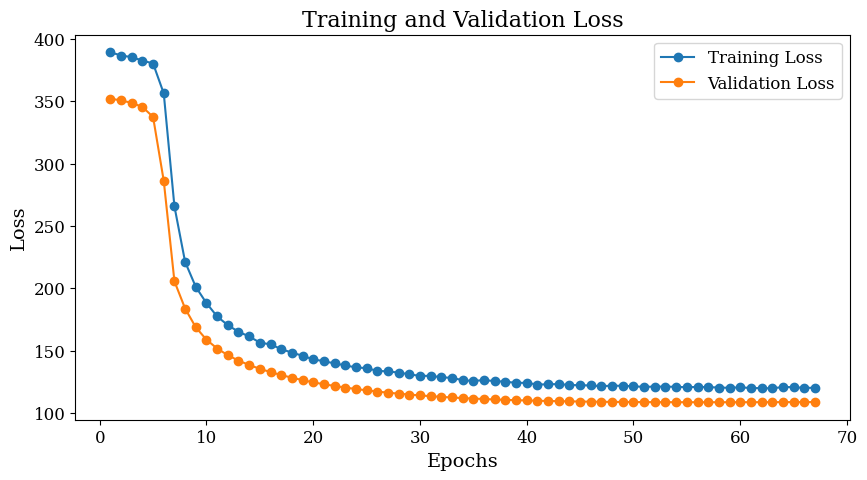

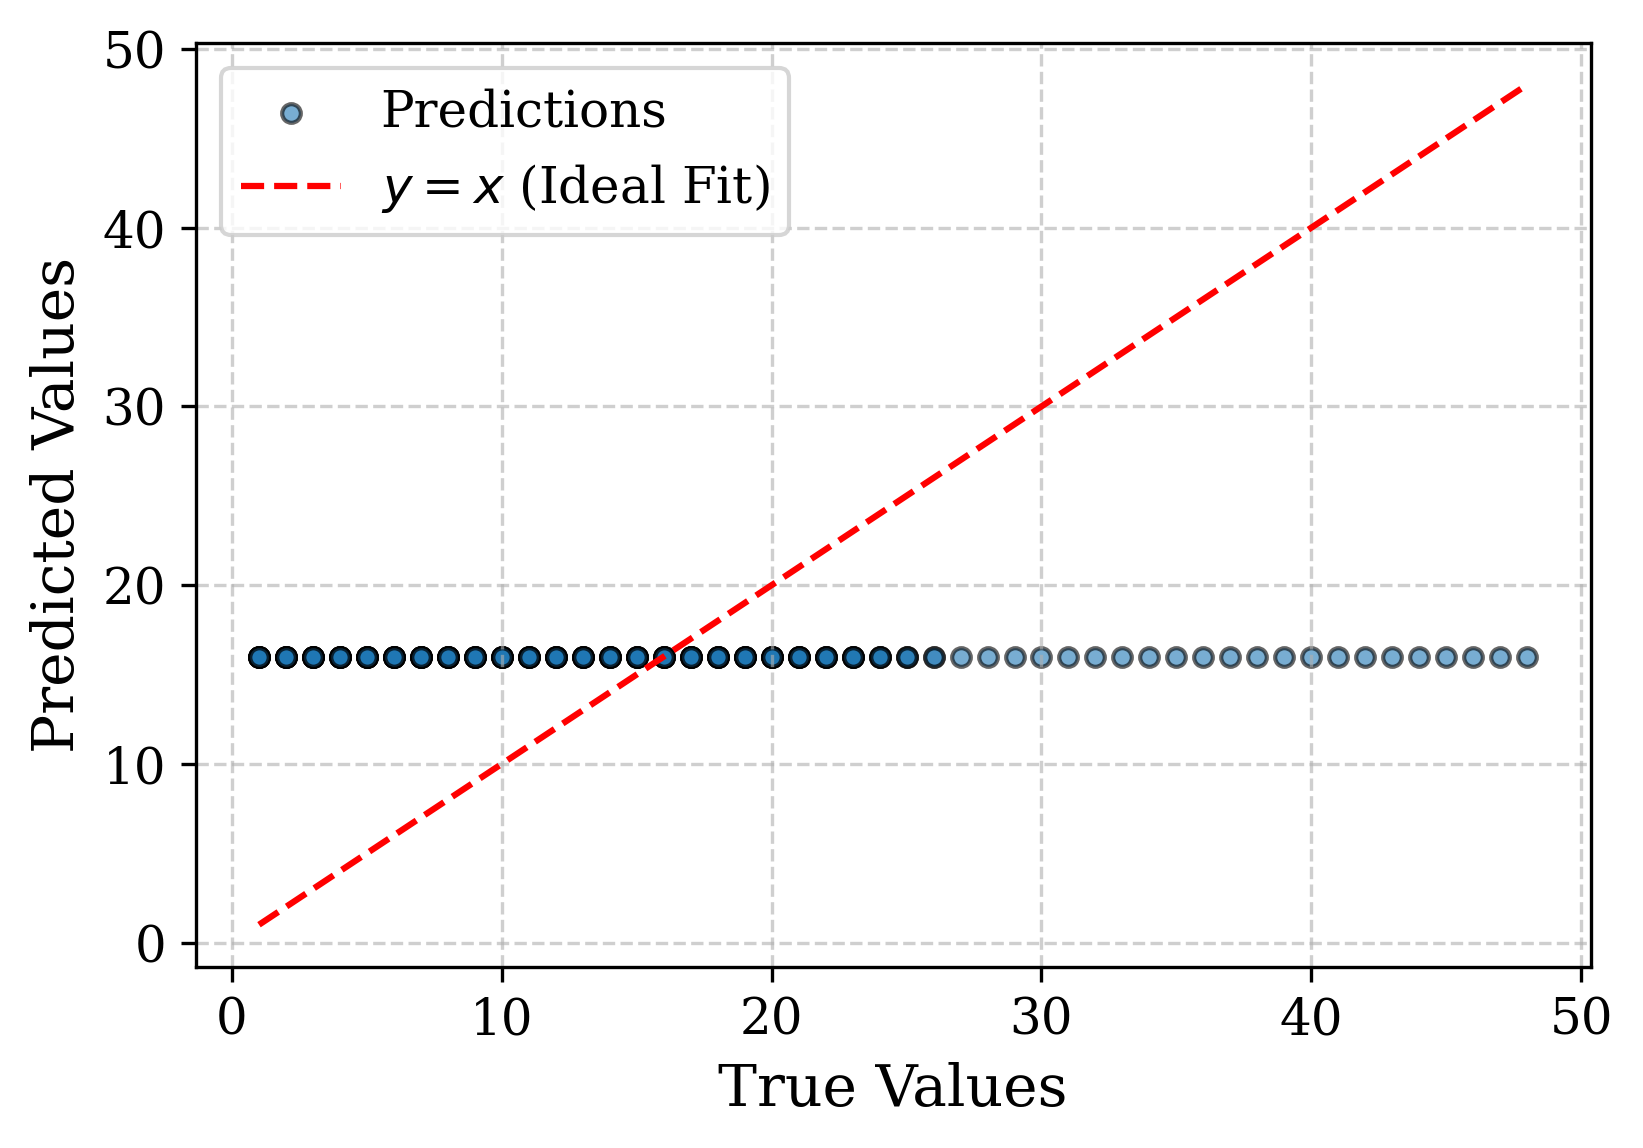

Evaluating motif 5 with size 12 and 47 indexes
X_series shape: torch.Size([1032, 504, 1])
X_indices shape: torch.Size([1032, 16, 1])
X_mask shape: torch.Size([1032, 504])
y shape: torch.Size([1032, 1])
Best epoch: 414
Test Loss: 135.65711975097656, Test MAE: 8.831181526184082, Test RMSE: 11.647193908691406
Best hyperparameters: {'learning_rate': 3.5689237562318656e-05, 'num_layers': 5, 'batch_size': 32, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 16, 'hidden_size_layer_3': 256, 'hidden_size_layer_4': 32}
Early stopping at epoch 425, with best epoch being 414


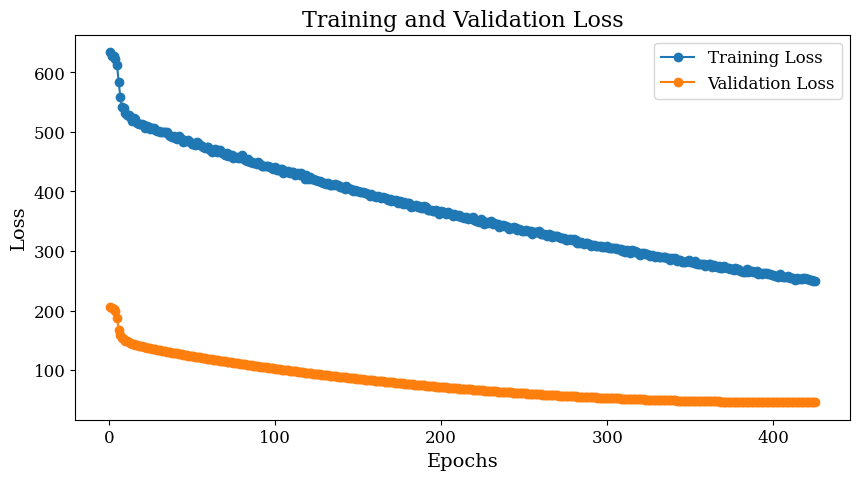

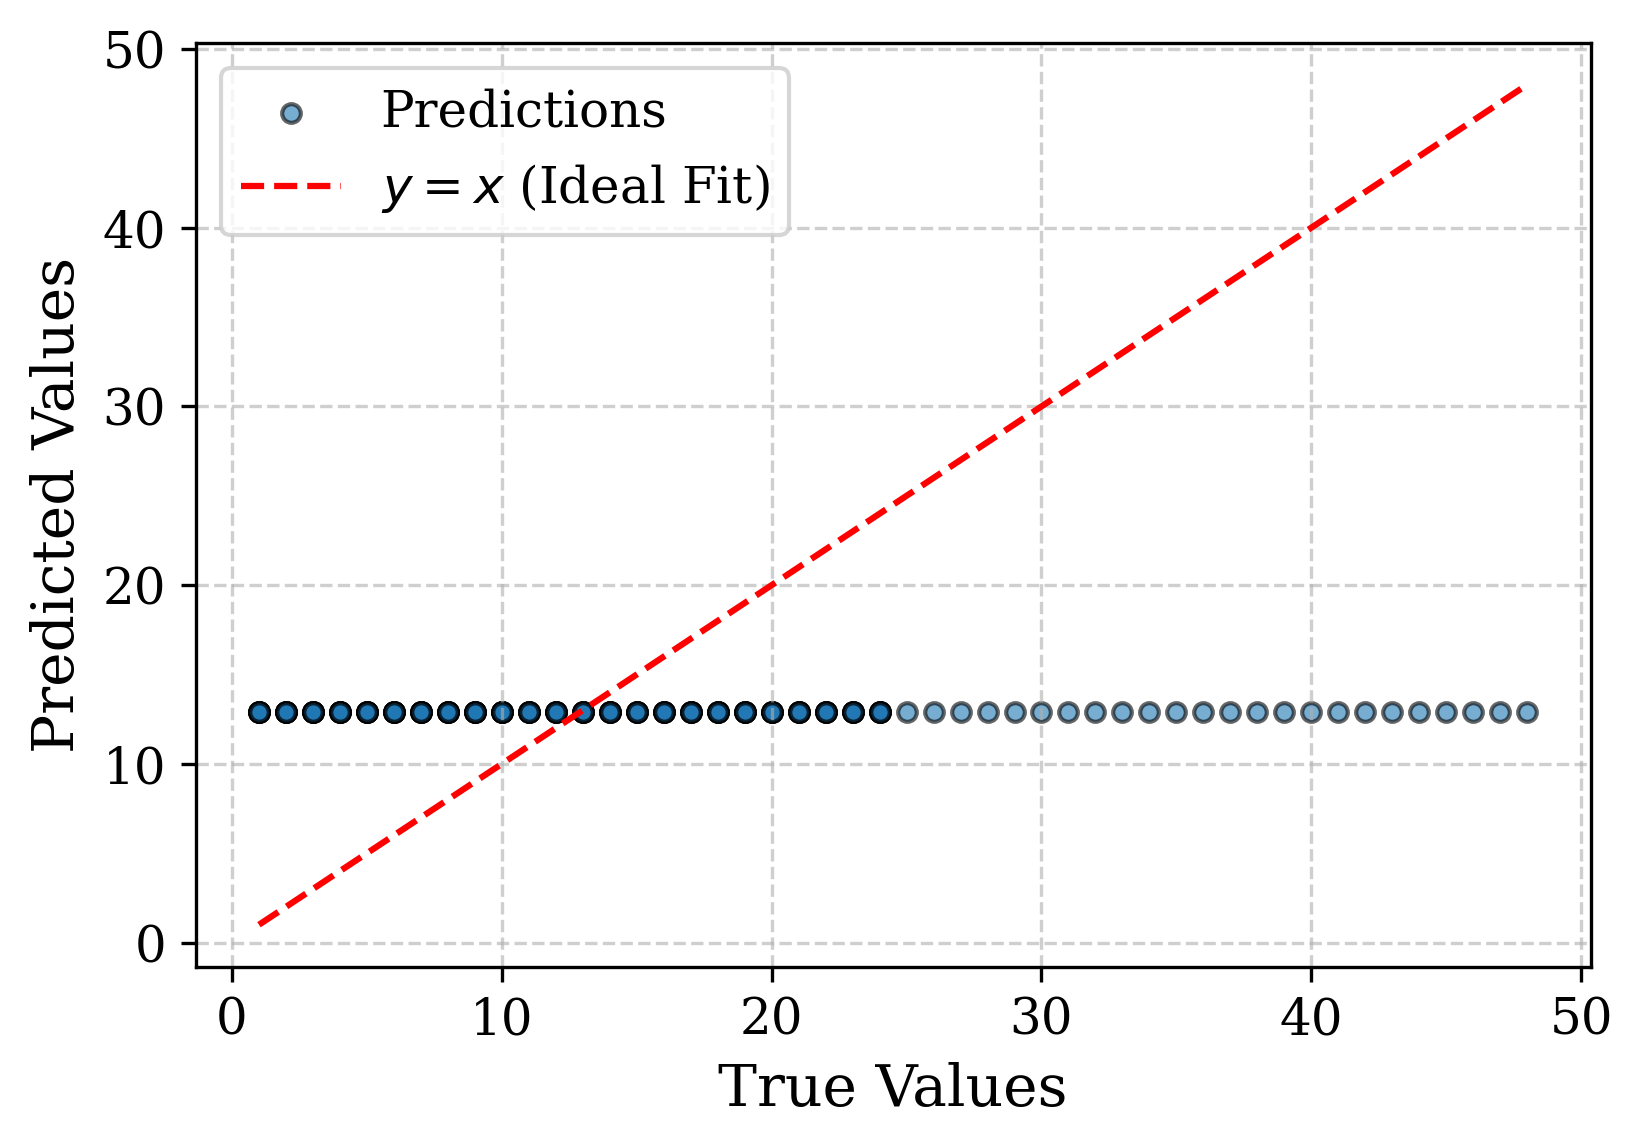

Evaluating motif 23 with size 12 and 46 indexes
X_series shape: torch.Size([1122, 504, 1])
X_indices shape: torch.Size([1122, 16, 1])
X_mask shape: torch.Size([1122, 504])
y shape: torch.Size([1122, 1])
Best epoch: 81
Test Loss: 134.55264282226562, Test MAE: 9.551698684692383, Test RMSE: 11.599682807922363
Best hyperparameters: {'learning_rate': 0.0005490177254843733, 'num_layers': 1, 'batch_size': 32, 'hidden_size_layer_0': 16}
Early stopping at epoch 92, with best epoch being 81


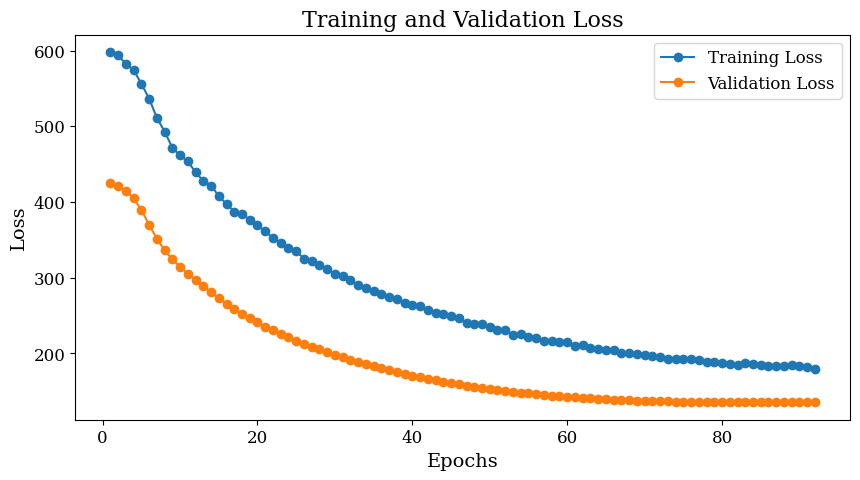

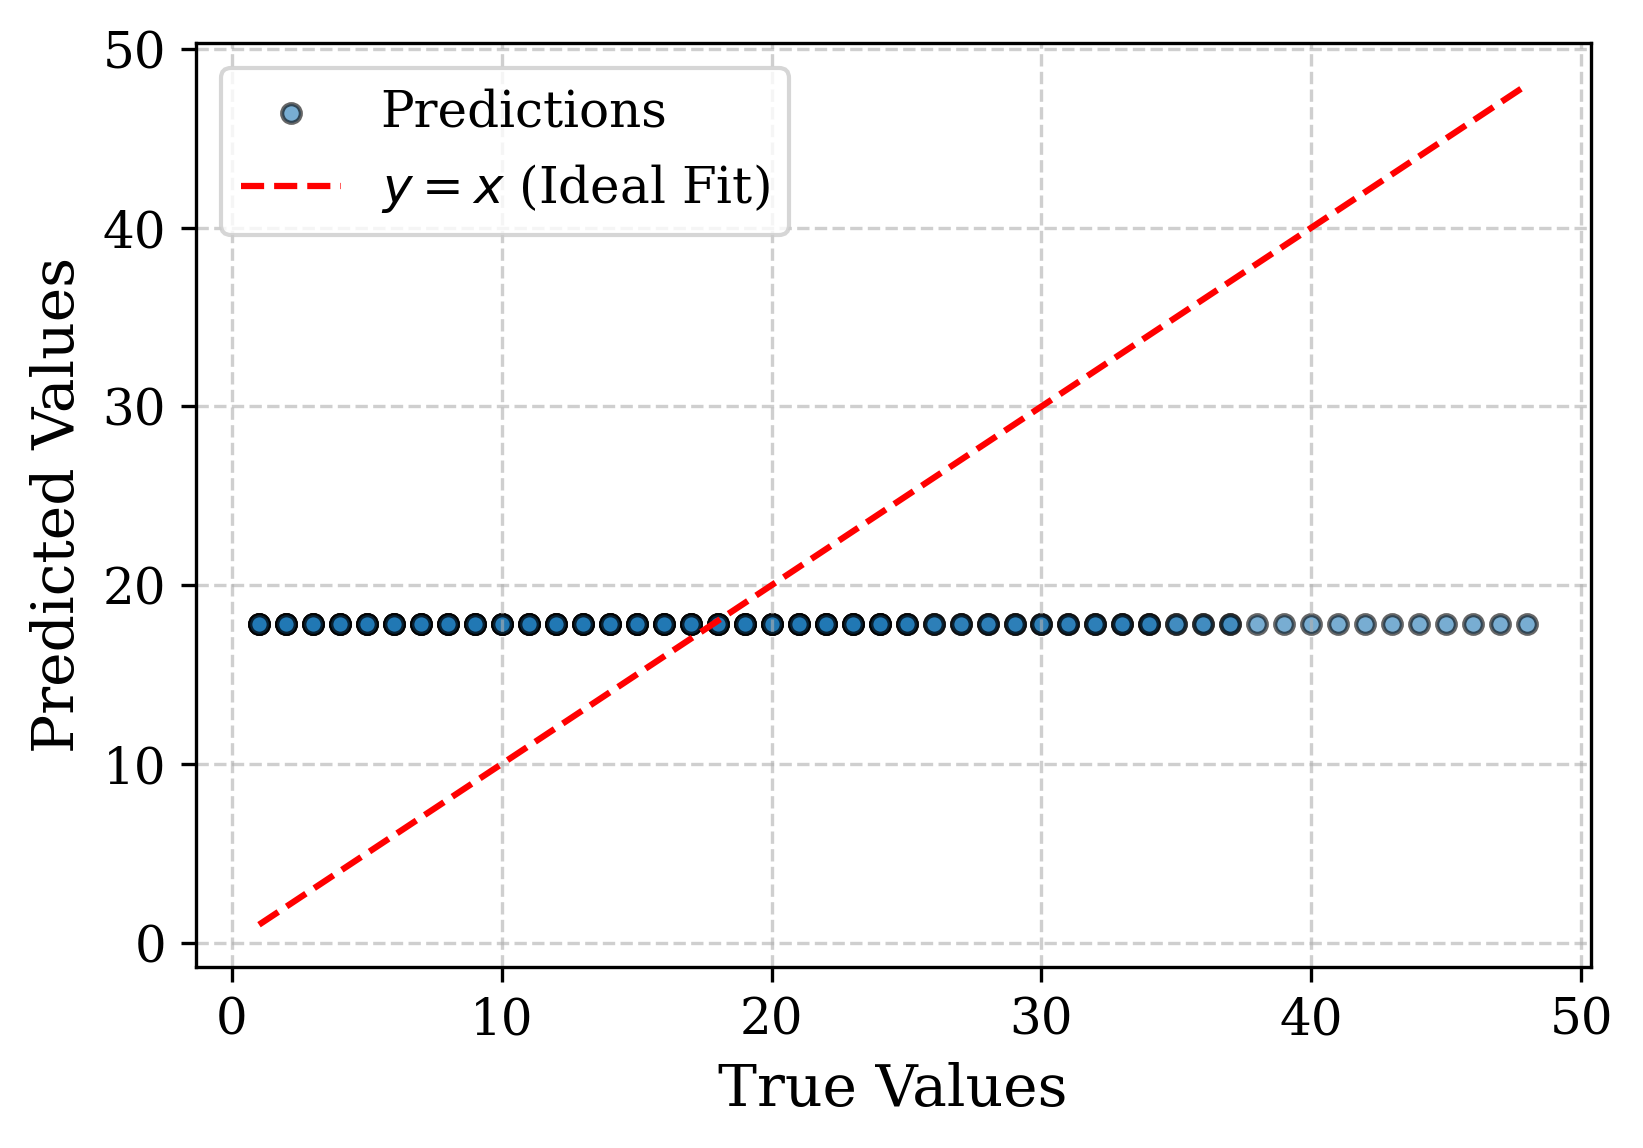

Evaluating motif 11 with size 12 and 44 indexes
X_series shape: torch.Size([1050, 504, 1])
X_indices shape: torch.Size([1050, 15, 1])
X_mask shape: torch.Size([1050, 504])
y shape: torch.Size([1050, 1])
Best epoch: 276
Test Loss: 173.5846710205078, Test MAE: 10.653692245483398, Test RMSE: 13.175153732299805
Best hyperparameters: {'learning_rate': 1.6303665772534352e-05, 'num_layers': 1, 'batch_size': 16, 'hidden_size_layer_0': 64}
Early stopping at epoch 287, with best epoch being 276


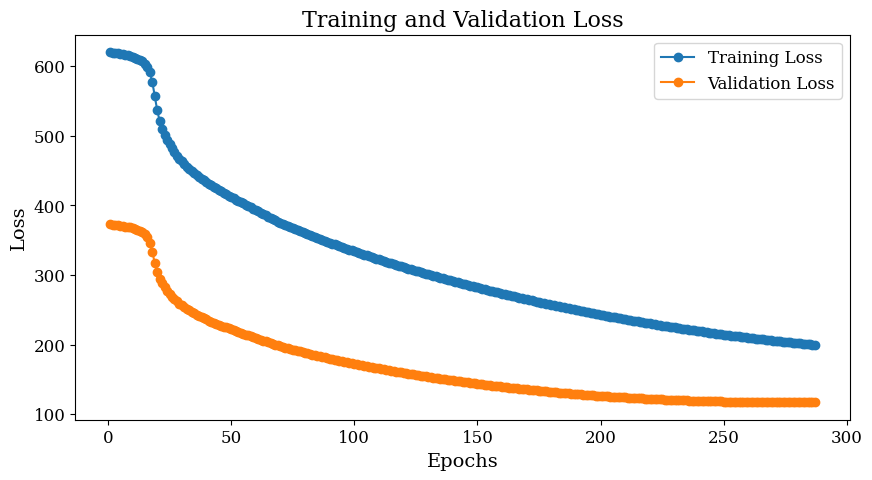

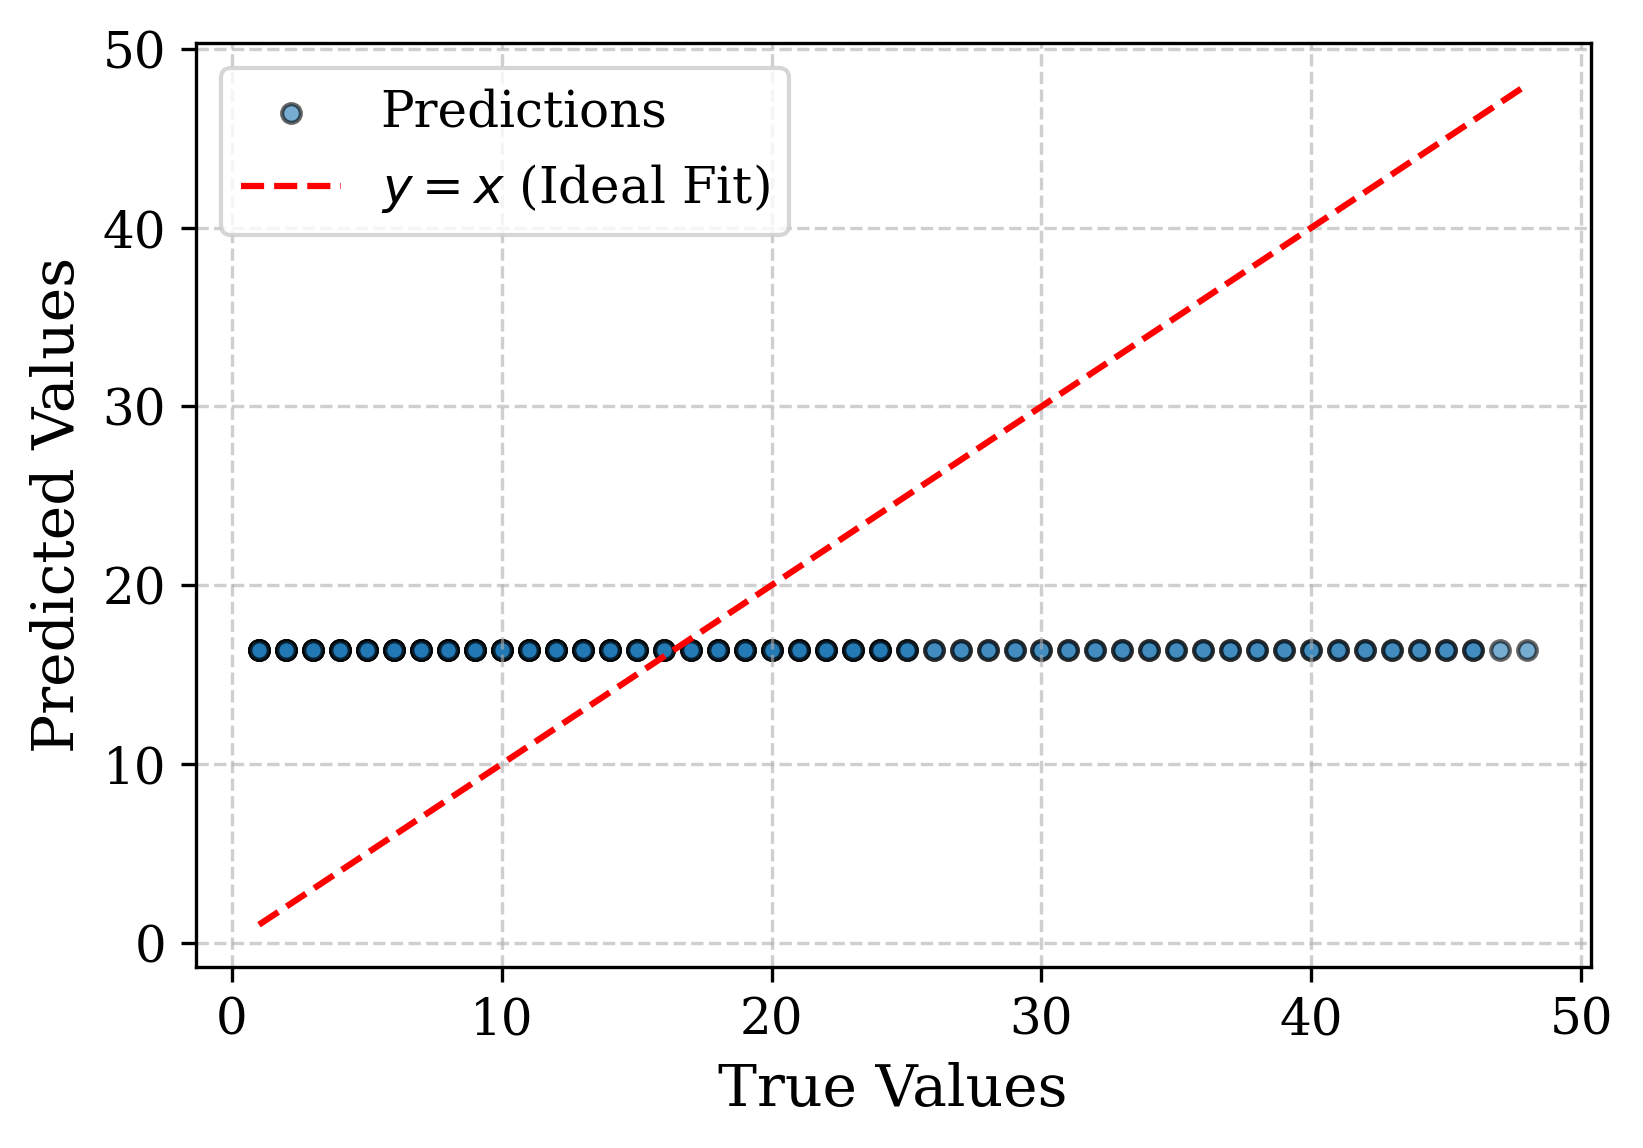

Evaluating motif 6 with size 12 and 38 indexes
X_series shape: torch.Size([979, 504, 1])
X_indices shape: torch.Size([979, 12, 1])
X_mask shape: torch.Size([979, 504])
y shape: torch.Size([979, 1])
Best epoch: 55
Test Loss: 188.24232482910156, Test MAE: 11.205948829650879, Test RMSE: 13.72014331817627
Best hyperparameters: {'learning_rate': 3.145834231672206e-05, 'num_layers': 1, 'batch_size': 32, 'hidden_size_layer_0': 256}
Early stopping at epoch 66, with best epoch being 55


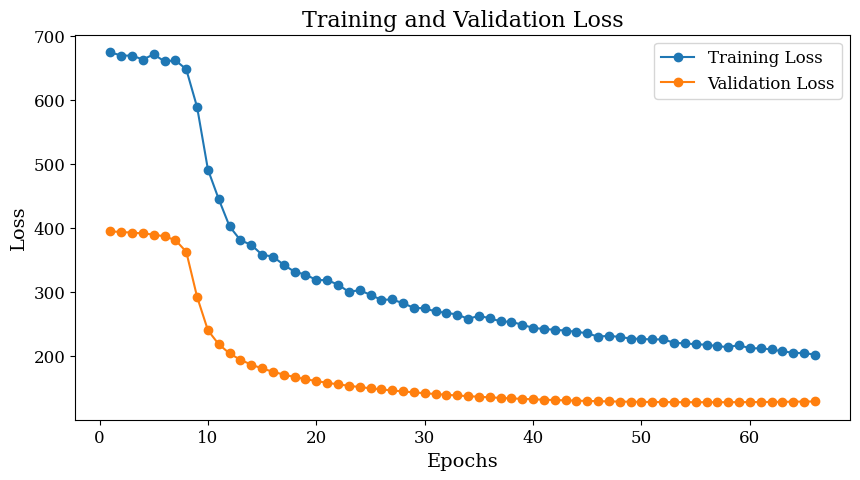

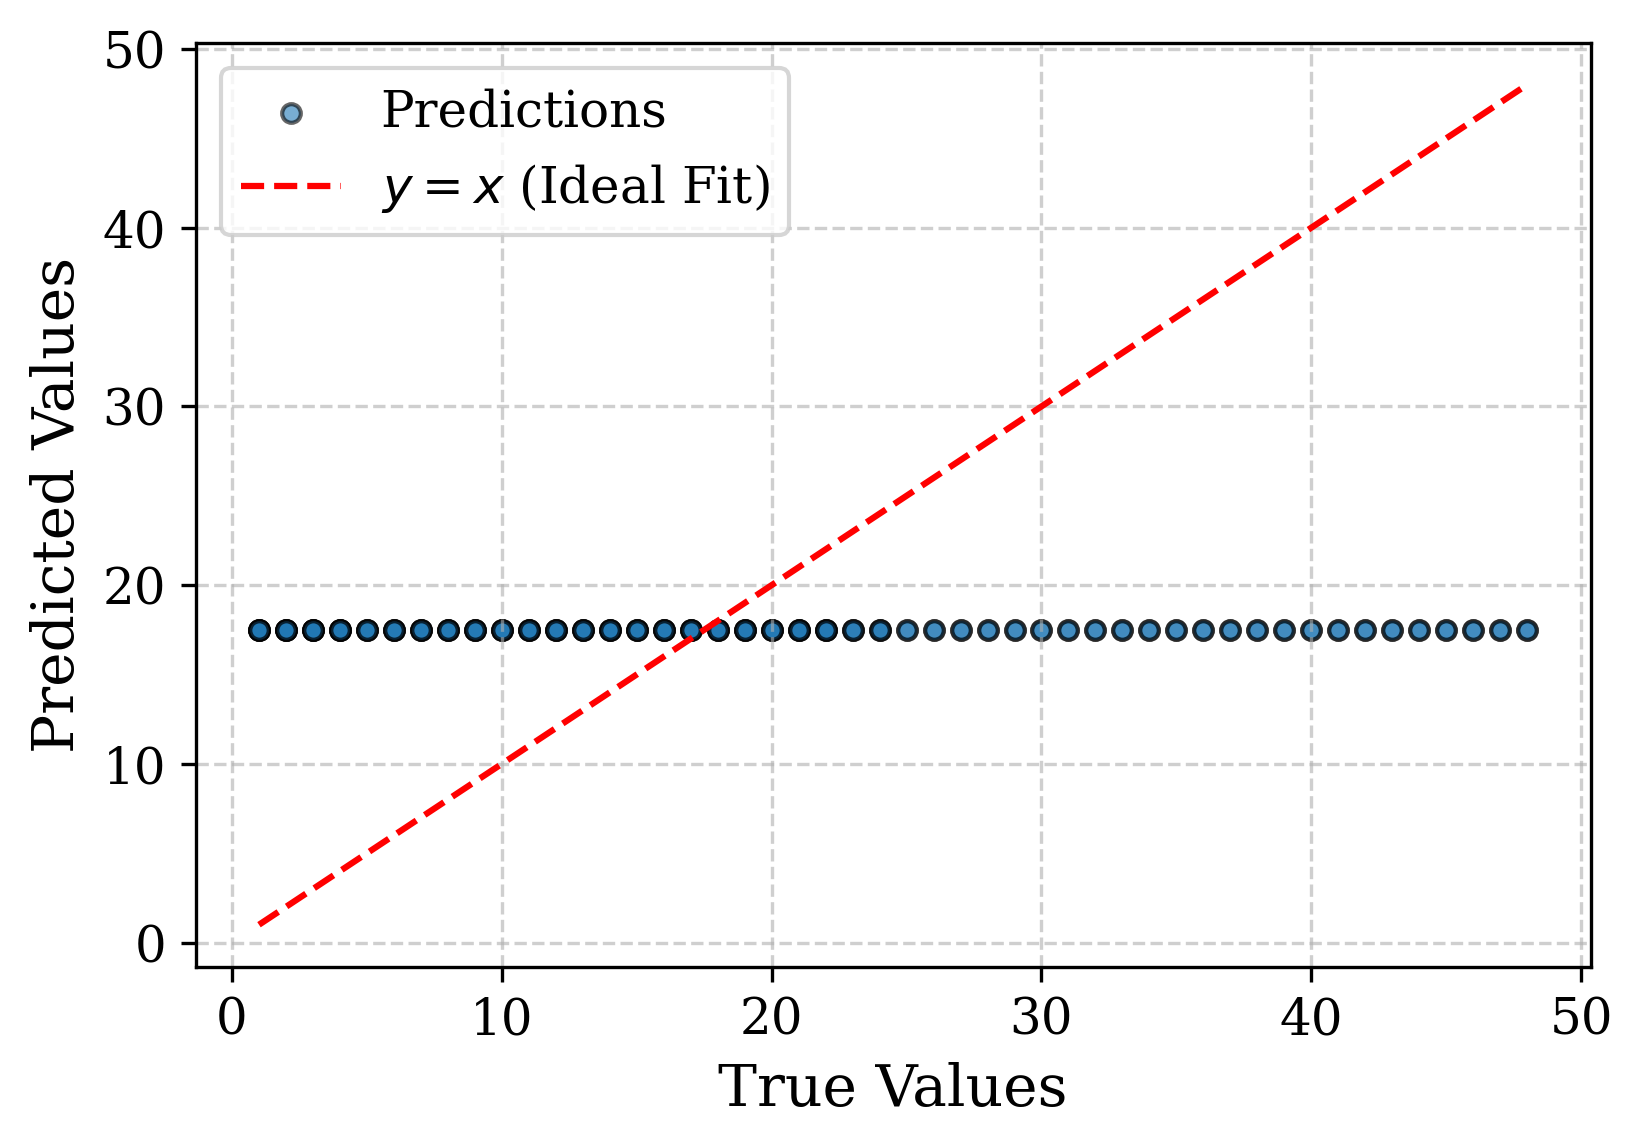

Aggregated Results Across Top 5 Motifs:
Mean Test Loss: 150.45521697998046 ± 25.87552028129941
Mean Test MAE: 9.783667755126952 ± 0.9968147215513952
Mean Test RMSE: 12.221508598327636 ± 1.0440053513070067


In [8]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.lstm_pytorch import LSTM
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():

    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "LSTM"
    model_name = "LSTMIndexes"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1,3,5]]  
        },
        "batch_size": {
            "type": "categorical",
            "args": [[4, 8, 16, 32]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_indices": X_indices}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    plot_best_model_results_traindevtest( study.trials_dataframe(),
       save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    )    
    plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")
